In [116]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from IPython.display import display
from skimage import io
%matplotlib inline
from PIL import Image
import json
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [2]:
import torch
# from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, datasets, models
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.nn import functional as F

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# !ls "/content/gdrive/My Drive"
try:
    data_dir = "./gdrive/My Drive/data"
except:
    data_dir = "/data"

Mounted at /content/gdrive


## 2. Transfer Learning: ResNet50

In this notebook we train/fine-tune the pretrained ResNet50 model using ```PyTorch``` on ```gpu```.
We first make the appropriate transformations on the data, then add a few more layers to ResNet50, and train/validate the model.

The plots indicating how the loss and metric (accuracy) changes throughout the
training and validation are provided also below after training.

Afterwards, we save the weights of our trained model.

In the last section, we test our model against test data, present metrics.

There are also additional discussions at each section on the choice of
additional layers, learning rate, epochs and batch-size.

### Data Transforms

Here we perform data transformations on the train/val sets. For both cases, we resize each image to 224x224 since this is the least size the ResNet accepts. Additionally, we apply a few data augmentation techniques on the training set to reduce the overfitting. Since rotating and flipping flower images don't
change their classes, we apply these transformations.

We also apply a normalization, the mean and std of which we use the Imagenet
data (normally that of the training set should be used to calculate the mean and std, but for demonstration purposes we skip this).

We use the functionalities of ```PyTorch``` to apply these transformations and to save them.

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
# Resize step is required as we will use a ResNet model, which accepts at least 224x224 images

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Imagenet standards
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        # transforms.RandomRotation(degrees=90),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [5]:
# data_dir = 'data'
image_datasets = {x:
                  datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x:
               torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                           shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
device

device(type='cuda', index=0)

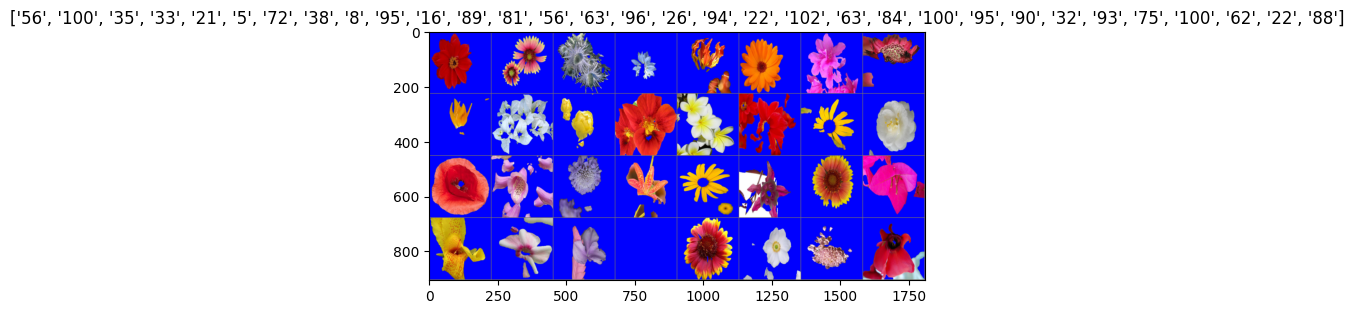

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

<br><BR/>

### Training and Finetuning the Model

Here we import the ResNet50 model, making sure that the ```pretrained``` is set to ```True```, to fully transfer the weights, and ```param.requires_grad```
is ```False``` so that during the training, we don't change the already set
weights by backpropagating more.

We add additionally two linear layers and a dropout in between. Before
dropout, the performance of the model on the train/val sets were quite
different, i.e. the model was overfitting. Dropout was added to reduce
overfitting.

We also experimented with different learning rates, ranging between
```lr=1e-1``` and ```lr=1e-4```, and decided on the ```lr=1e-4```.

Additional hyperparameters to tune could be the optimizer, number of epochs,
and batch-size, for which the package ```Ray``` could be used.

Here our model performs 0.7 accuracy on both validation and test sets. To increase the performance, we can add additional layers to the model for it to be able to handle more complexity, in addition to hyperparameter tuning.


In [8]:
model_ft = models.resnet50(pretrained=True).to(device)

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
              nn.Linear(num_ftrs, 512),
              nn.ReLU(inplace=True),
              nn.Dropout(0.4),
              nn.Linear(512, len(class_names))).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.fc.parameters(), lr=1e-4) #  0.0001

In [10]:
loss_history = {'train': [], 'val': []}
metric_history = {'train': [], 'val': []}

In [11]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

#             if phase == 'train':
#                 scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])\

            loss_history[phase].append(epoch_loss)
            metric_history[phase].append(epoch_acc)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [12]:
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=100)

Epoch 1/100
----------
train loss: 4.6296, acc: 0.0118
val loss: 4.5388, acc: 0.0618
Epoch 2/100
----------
train loss: 4.5071, acc: 0.0598
val loss: 4.4418, acc: 0.1206
Epoch 3/100
----------
train loss: 4.4027, acc: 0.0902
val loss: 4.3260, acc: 0.2539
Epoch 4/100
----------
train loss: 4.2548, acc: 0.1529
val loss: 4.1877, acc: 0.3441
Epoch 5/100
----------
train loss: 4.1116, acc: 0.2020
val loss: 4.0368, acc: 0.3912
Epoch 6/100
----------
train loss: 3.9672, acc: 0.2549
val loss: 3.8998, acc: 0.4314
Epoch 7/100
----------
train loss: 3.8110, acc: 0.2775
val loss: 3.7437, acc: 0.4255
Epoch 8/100
----------
train loss: 3.6286, acc: 0.3627
val loss: 3.5794, acc: 0.5059
Epoch 9/100
----------
train loss: 3.5026, acc: 0.3578
val loss: 3.4231, acc: 0.5137
Epoch 10/100
----------
train loss: 3.2864, acc: 0.4284
val loss: 3.2783, acc: 0.5578
Epoch 11/100
----------
train loss: 3.1547, acc: 0.4422
val loss: 3.1408, acc: 0.5412
Epoch 12/100
----------
train loss: 2.9957, acc: 0.4882
val los

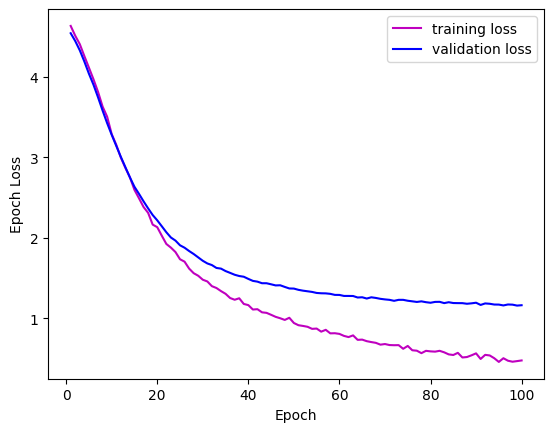

In [13]:
epochs = list(range(1, 101))
plt.plot(epochs, loss_history['train'], 'm', label='training loss')
plt.plot(epochs, loss_history['val'], 'b', label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Epoch Loss")
plt.legend()
plt.show()

In [14]:
metric_history_cpu = {'train': [], 'val': []}
for phase in ['train', 'val']:
    metric_history_cpu[phase] = [elem.item() for elem in metric_history[phase]]

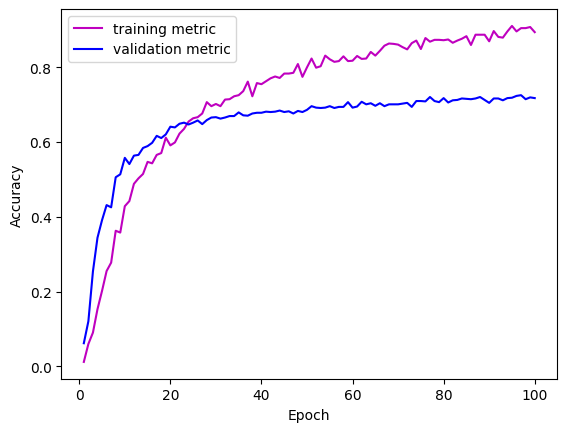

In [15]:
epochs = list(range(1, 101))
plt.plot(epochs, metric_history_cpu['train'], 'm', label='training metric')
plt.plot(epochs, metric_history_cpu['val'], 'b', label='validation metric')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# save the model
# !mkdir data_dir + "/models"

In [16]:
torch.save(model_ft.state_dict(), os.path.join(data_dir, 'models/weights_resnet50_fine_tuned.h5'))

<br><BR/>

### Load the Model

Reloading the weights of the model; making sure the architecture the same as the one we trained our data on.

In [23]:
model = models.resnet50(pretrained=True).to(device)

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
              nn.Linear(num_ftrs, 512),
              nn.ReLU(inplace=True),
              nn.Dropout(0.4),
              nn.Linear(512, len(class_names))).to(device)
model.load_state_dict(torch.load(os.path.join(data_dir, 'models/weights_resnet50_fine_tuned.h5')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

<br><BR/>

### Make Predictions on the Test Set

Here we test our model on the test data and compare the predicted results with the labels. We make sure that the model is in evaluation mode.

We test the images in pairs, collecting the results in a list, and delete the cached data immediately after each iteration, because otherwise one runs into memory problems.

The overall accuracy is about 0.7, similar to the perfomance of the model on the validation set.

Because the test dataset is imbalanced, we also calculate the F1 score below.

In [29]:
def test_accuracy(test_sample, model):
    img_list = [Image.open(os.path.join(test_dir, img_path)) for img_path in test_sample]
    test_batch = torch.stack([data_transforms['val'](img).to(device) for img in img_list])

    pred_logits_tensor = model(test_batch)
    _, predicted = torch.max(pred_logits_tensor, 1) # F.softmax(pred_logits_tensor_example, dim=1).cpu().data.numpy()

    for i in range(len(img_list)):
    predictions[test_sample[i]] = class_names[predicted[i].item()]
    correct_predictions = sum(labels_test[test_sample[i]] == predictions[test_sample[i]] for i in range(len(img_list)))
    return correct_predictions


In [30]:
labels_test = json.load(open(data_dir + "/labels_test.json"))

In [31]:
model.eval()
# all test data:
sample_size = 1000
test_dir = os.path.join(data_dir, 'test/')
test_file_names = sorted(os.listdir(test_dir))

number_of_correct_predictions = 0
number_of_test_samples = 0
predictions = {}
i = 0
with torch.no_grad():
    while i <= (len(test_file_names)-2):
        number_of_correct_predictions += test_accuracy(test_file_names[i:i+2], model)
        i += 2
        number_of_test_samples = i
        torch.cuda.empty_cache()

In [32]:
print (number_of_correct_predictions)
print (number_of_test_samples)

4301
6148


### Accuracy on the Test Set

In [33]:
accuracy_test = number_of_correct_predictions / number_of_test_samples
print ("accuracy on the test set: ", accuracy_test)

accuracy on the test set:  0.6995770982433311


<br><BR/>

### F1 Score on the Test Set

In [107]:
df_predictions_vs_actual = pd.DataFrame({'actual':pd.Series(labels_test),'predicted':pd.Series(predictions)})
df_predictions_vs_actual.dropna(inplace=True)
df_predictions_vs_actual['actual'] = df_predictions_vs_actual['actual'].astype(int)
df_predictions_vs_actual['predicted'] = df_predictions_vs_actual['predicted'].astype(int)

In [108]:
df_predictions_vs_actual.head()

,actual,predicted
segmim_00001.jpg,77,77
segmim_00002.jpg,77,77
segmim_00003.jpg,77,20
segmim_00004.jpg,77,38
segmim_00005.jpg,77,77


In [109]:
df_predictions_vs_actual.shape

(6148, 2)

In [112]:
f1_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average='weighted')

0.7046151038117655

In [114]:
f1_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average='macro')

0.6890730978197827

In [125]:
print ("F1 score per class: \n", f1_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average=None))

F1 score per class: 
 [0.59090909 0.84507042 0.25454545 0.27777778 0.78481013 0.65714286
 0.5483871  0.84285714 0.53333333 0.85106383 0.43243243 0.88188976
 0.64864865 0.72413793 0.64367816 0.64       0.84126984 0.63492063
 0.81967213 0.52       0.68085106 0.80898876 0.85483871 0.85714286
 0.7        0.58333333 0.82051282 0.4556962  0.75925926 0.73770492
 0.50847458 0.39344262 0.53846154 0.84210526 0.62745098 0.6
 0.92045455 0.19444444 0.2295082  0.23762376 0.85436893 0.775
 0.59428571 0.59803922 0.5        0.76923077 0.95833333 0.7962963
 0.82352941 0.91025641 0.3630363  0.79710145 0.45901639 0.88607595
 0.84       0.90285714 0.71428571 0.92929293 0.9375     0.93333333
 0.82857143 0.76470588 0.95522388 0.81578947 0.80722892 0.98795181
 0.39344262 0.57731959 0.8358209  0.78431373 0.96491228 0.512
 0.85185185 0.67647059 0.73291925 0.7037037  0.81463415 0.64978903
 0.61538462 0.73988439 0.84644195 0.56774194 0.62443439 0.62385321
 0.68571429 0.74157303 0.36065574 0.57534247 0.76452599 0.

In [124]:
print ("precision macro: ", precision_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average='macro'))
print ("precision micro: ", precision_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average='micro'))
print ("precision weighted: ", precision_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average='weighted'))
print ("")
print ("precision per class: \n", precision_score(df_predictions_vs_actual['actual'], df_predictions_vs_actual['predicted'], average=None))

precision macro:  0.6877853969459058
precision micro:  0.6995770982433311
precision weighted:  0.7474740031059305

precision per class: 
 [0.54166667 0.96774194 0.2        0.27777778 0.91176471 0.51111111
 0.4047619  0.78666667 0.40816327 0.90909091 0.54545455 0.93333333
 0.53333333 0.7        0.48275862 0.55172414 0.86885246 0.625
 0.78125    0.40625    0.59259259 0.72       1.         0.77777778
 0.73684211 0.51851852 0.84210526 0.54545455 0.82       0.78947368
 0.55555556 0.33333333 0.53846154 0.88888889 0.57142857 0.66666667
 0.92045455 0.11666667 0.175      0.22222222 0.88888889 0.75609756
 0.8        0.46564885 0.36363636 0.80246914 0.93877551 0.75438596
 0.71794872 0.8452381  0.84615385 0.75342466 0.57142857 0.92105263
 0.85714286 0.91860465 0.61538462 0.88461538 0.91836735 0.92307692
 0.725      0.76470588 0.96969697 0.70454545 0.79761905 0.97619048
 0.30769231 0.44444444 0.84848485 0.66666667 0.98214286 0.65306122
 0.92       0.76033058 0.96721311 0.76       0.93296089 0.64166

<br><BR/>

<br><Br/>